In [11]:
%reload_ext autoreload
%autoreload 2

# OP apportionment

Weber S, ...

## Abstract

Oxidative potential (OP) has been proposed as a measure of toxicity of PM...

## Introduction

...

## Methodology

### Sampling sites

### Analysis

#### Chemical

#### OP AA/DTT(/DCFH?)

### Statistical framework

#### PMF
Blabla

Evolution from the SOURCES programme: SOURCESv2

PMF profils:

- base run (same as SOURCES) 
- constraints (same as SOURCES)
- Bootstrap
- mean of bootstrap as reference for the profils (SOURCESv2, not from the ref. constraint run)
- PM contribution reconstructed from the mean PM of each bootstrap profils (SOURCESv2, not from the ref. constraint run) 

#### Mulitple linear regression




In [2]:
import pandas as pd
import statsmodels.api as sm 
from statsmodels.tools.tools import add_constant

def solve_WLS(X=None, y=None, sigma=None):
    """
    Solve a multiple linear problem using statsmodels WLS with positivity constraint
    according to Weber et al. (2018)
    """
    goForWLS = add_constant(X.copy())
    regr = sm.WLS(y, goForWLS, weights=sigma, cov_type="fixed_scale").fit()
    while True:
        regr = sm.WLS(y, goForWLS, weights=sigma, cov_type="fixed_scale").fit()
        paramstmp=regr.params.copy()
        paramstmp["const"]=10
        # if (regr.pvalues > 0.05).any():
        if (paramstmp < 0).any():
            # Some variable are 0, drop them.
            # goForWLS.drop(goForWLS.columns[regr.pvalues>0.05],axis=1,inplace=True)
            # goForWLS.drop(goForWLS.columns[regr.pvalues == max(regr.pvalues)],axis=1,inplace=True)
            goForWLS.drop(goForWLS.columns[paramstmp == min(paramstmp)],axis=1,inplace=True)
            # print(regr.summary())
        else:
            # Ok, the run converged
            break
        if goForWLS.shape[1]==0:
            # All variable were droped... Pb
            print("Warning: The run did not converge...")
            break
    # print(regr.summary())
    return regr

## Results

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
from Station import Station
from scripts.load_data import getDataFromDB

DB_PM = "/home/webersa/Documents/BdD/BdD_PM/db.sqlite"
PROGRAMMES = ["SOURCES", "SOURCES2"]
list_OPtype = ["DTTv", "AAv"]
list_station = [
    #"PdB", "MRS-5av", "Nice", "Aix-en-provence",
    #"GRE-fr", "Marnaz", "Chamonix", "Passy",
    #"Nogent", "Roubaix", #"Rouen",
    #"STG-cle", #"Talence"
    "Chamonix", "GRE-fr"
]

conn = sqlite3.connect(DB_PM)
contributions, profiles, dfPM_all = getDataFromDB(
    conn=conn,
    programmes=PROGRAMMES
)
conn.close()



map_station_name = {
    "CHAM": "Chamonix",
    "GRE": "GRE-fr"
}

contributions.replace(map_station_name, inplace=True)
profiles.replace(map_station_name, inplace=True)

NBOOT = 50

list_station.sort()
list_OPtype.sort()
sto = {}
for name in list_station:
    if name not in contributions["station"].unique():
        continue

    print(name)
    station = Station(name=name, list_OPtype=list_OPtype)
    station.load_SRC(
        dfcontrib=contributions[contributions["station"]==name],
        dfprofile=profiles[profiles["station"]==name]
    )
    station.setSourcesCategories()
    station.load_OP(dfPM_all[dfPM_all["station"]==name])
    station.OPi = pd.DataFrame(index=station.SRC.columns, columns=list_OPtype)
    
    for OPtype in list_OPtype:
        if not(OPtype in station.OP.columns) or station.OP[OPtype].isnull().all() or station.OP[OPtype].empty:
            print("WARNING: no OP {}".format(OPtype))
            continue
        
        df = station.SRC.merge(station.OP[[OPtype, "SD_"+OPtype]], left_index=True, right_index=True, how="inner")
        
        # drop extreme value
        outliers = Outliers(station=name)
        mask_outliers = [False] * len(df.index)
        if name == "GRE-fr":
            mask_outliers = df.index != pd.to_datetime('2013-04-26')
            df = df[mask_outliers]
        
        df.dropna(inplace=True)
        if len(df)<=50:
            print("WARNING: not enought commun index: {}".format(len(df)))
            continue
        OP = df[OPtype]
        OPunc = df["SD_"+OPtype]
        SRC = df[station.SRC.columns]
        OP.name = OPunc.name = SRC.name = name
        
        # solve WLS
        regr = solve_WLS(X=SRC, y=OP, sigma=1/OPunc**2)
        station.reg[OPtype] = regr
        station.OPi.loc[:, OPtype] = regr.params[1:]
        station.OPi.loc[:, "SD_"+OPtype] = regr.bse[1:]
        station.OPi.sort_index(inplace=True)
        
        # Bootstrap solution
        pred = pd.DataFrame(index=SRC.index)
        for i in range(NBOOT):
            params = regr.bse * np.random.randn(len(regr.params)) + regr.params
            pred[i] = (params*SRC).sum(axis=1) + params["const"]
        station.OPmodel_unc[OPtype] = pred.std(axis=1)
        station.OPmodel[OPtype] = regr.params["const"]+(station.SRC * station.OPi[OPtype]).sum(axis=1)

    sto[name] = station

Chamonix


/home/webersa/Documents/inversionOP/Station.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcontrib.dropna(axis=1, how="all", inplace=True)
/home/webersa/.local/lib/python3.5/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/home/webersa/.local/lib/python3.5/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/

GRE-fr


,Aged_salt,Biomass_burning,Dust,Nitrate_rich,Primary_biogenic,Secondary_biogenic,Sulfate_rich,Traffic
date,,,,,,,,
2013-01-02,2.180815,4.360926,1.323874,0.876025,0.420546,0.009754,1.404130,0.239360
2013-01-05,0.340409,14.152312,1.134473,6.079457,0.742388,0.017578,1.350163,5.686161
2013-01-08,0.118640,15.812935,3.176647,11.365798,0.640646,0.080008,1.227755,9.231654
2013-01-11,0.021724,7.577089,-0.561940,2.558701,0.431901,0.003194,1.032120,4.380350
2013-01-14,0.129822,3.254096,1.977130,7.606302,0.079625,0.030774,2.947824,1.287970
2013-01-17,1.068822,5.935572,10.971878,18.696449,2.781219,0.149804,7.941251,3.748662
2013-01-20,0.069221,8.116434,0.850412,8.589889,0.218672,0.005845,2.136149,1.025811
2013-01-23,0.511659,15.720590,-0.561940,8.203742,0.816954,0.014618,-0.462440,12.666882
2013-01-26,1.074654,16.837092,1.929871,16.607419,0.400205,0.085519,2.459025,6.004417


In [6]:
df = pd.DataFrame()
for s in sto.keys():
    df = pd.concat([df, sto[s].OPi])
OPi = pd.DataFrame()
for source in df.index.unique():
    OPi.loc[source, "AAv"] = df.loc[source, "AAv"].mean()
    OPi.loc[source, "DTTv"] = df.loc[source, "DTTv"].mean()
    #OPi.loc[source, "DCFHv"] = df.loc[source, "DCFHv"].mean()
OPi

,AAv,DTTv
Biomass_burning,0.188133,0.175403
Dust,0.009845,0.111298
Nitrate_rich,NaN,0.035442
Primary_biogenic,0.045116,0.148613
Salt,0.037766,0.112759
Secondary_biogenic,0.020577,0.155095
Sulfate_rich,0.010662,0.133926
Traffic,0.190186,0.299941
Aged_salt,0.040863,0.182813


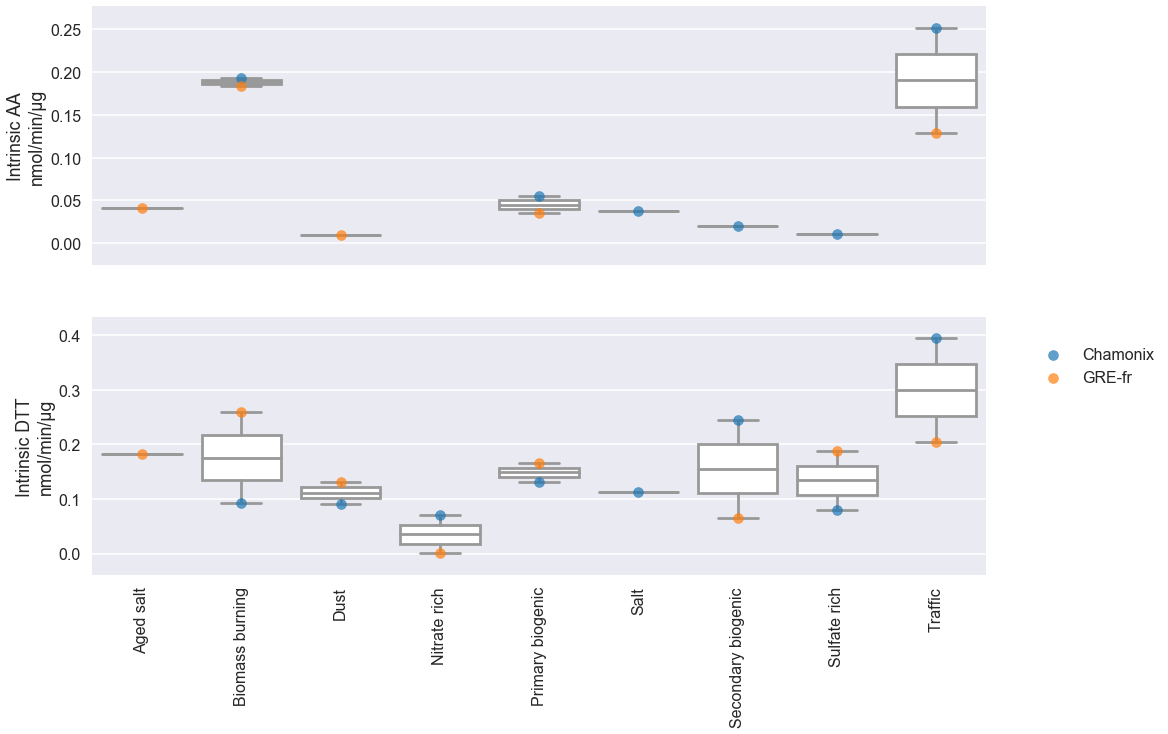

In [7]:
%matplotlib inline
from scripts.plot_utility import *
sns.set()
sns.set_context("poster")
plot_coeff_all_boxplot(sto, list_OPtype)

Chamonix
GRE-fr
Chamonix
GRE-fr


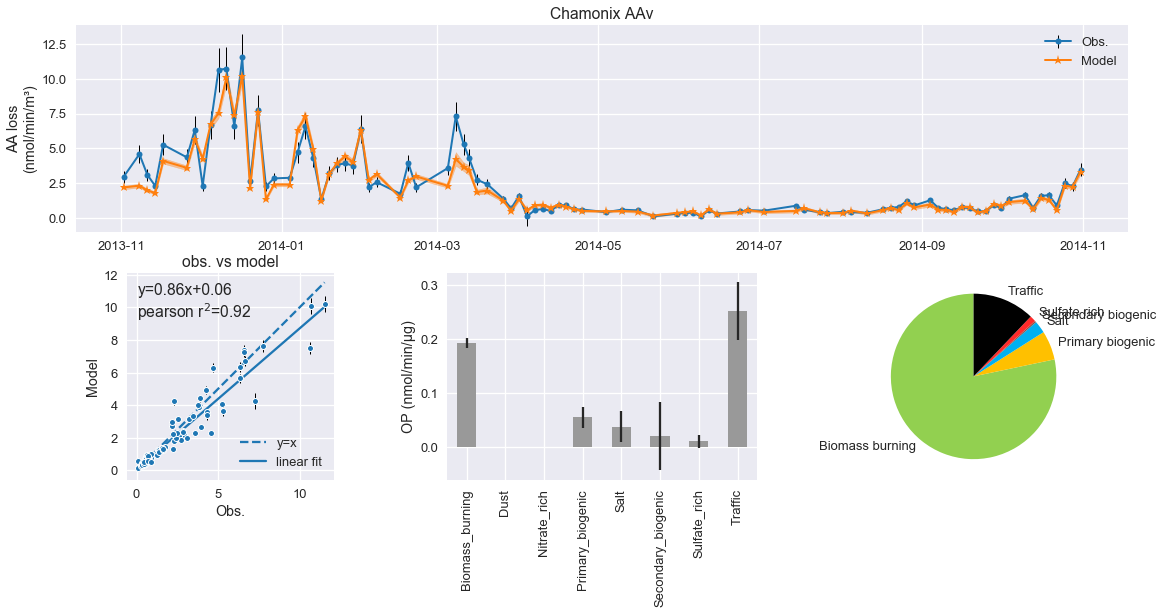

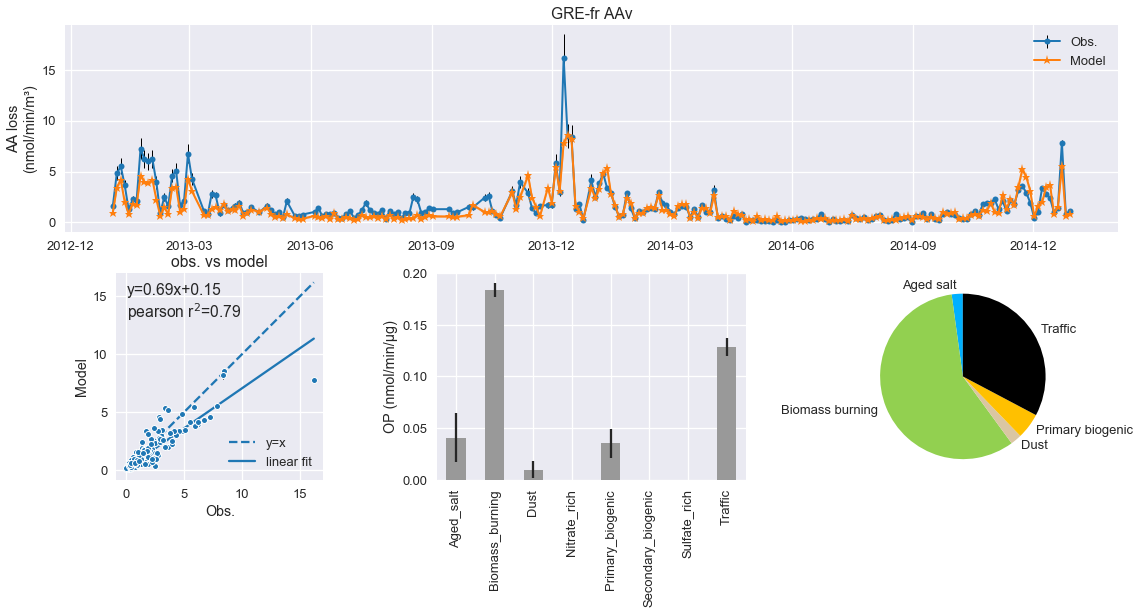

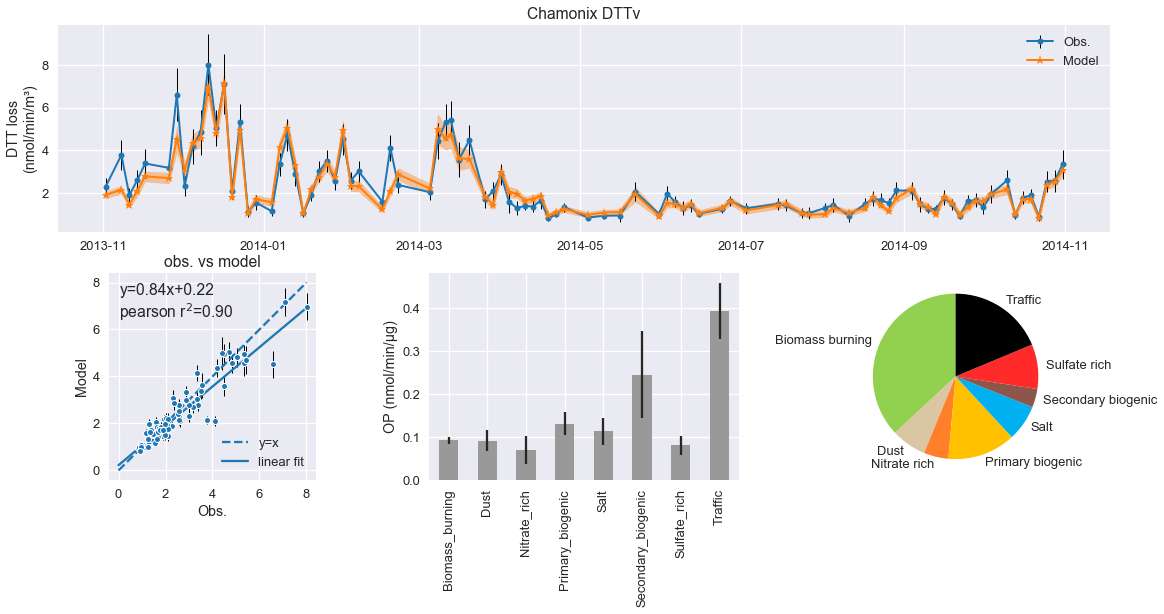

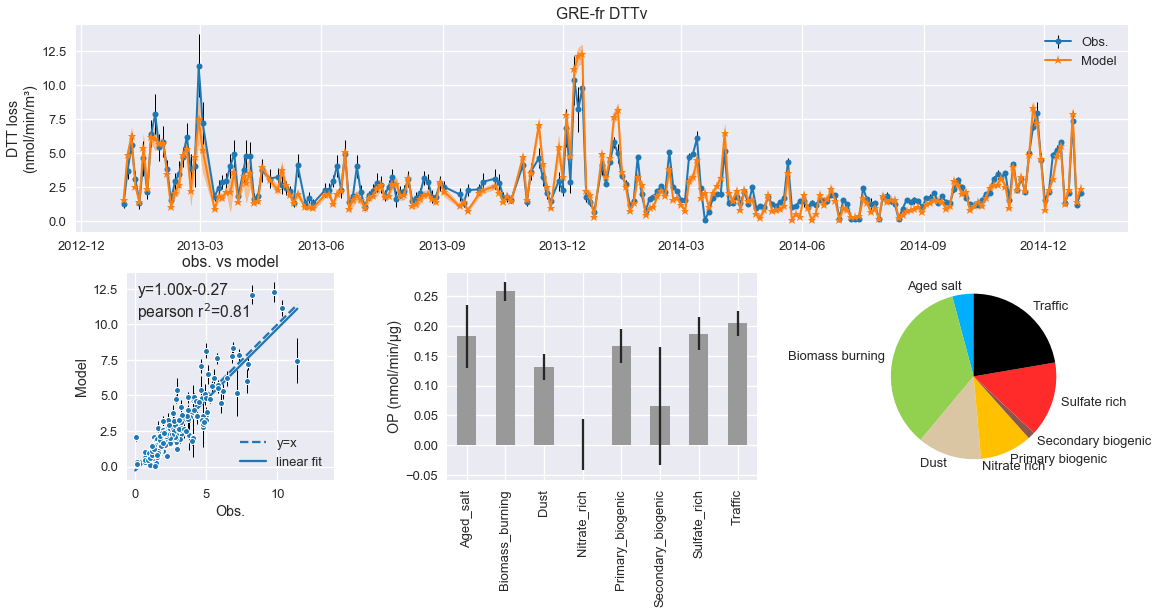

In [8]:
%matplotlib inline
sns.set_context("talk")
for OPtype in list_OPtype:
    for station in list_station: 
        if not OPtype in sto[station].OP.columns:
            continue
        if sto[station].OP[OPtype].empty or sto[station].OPmodel[OPtype].isnull().all():
            continue
        #if "Talence" in station:
        #    continue
        print(station)
        plot_station(sto[station], OPtype)
        #plot_save(OPtype+station, "/home/webersa/")
        

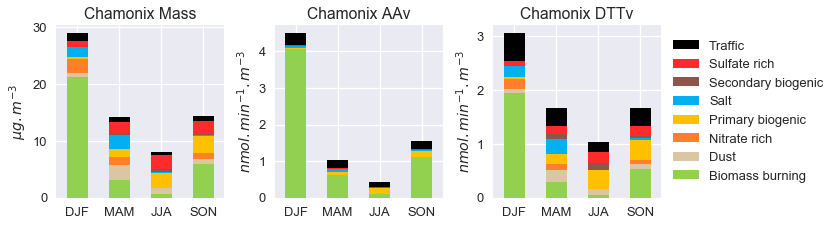

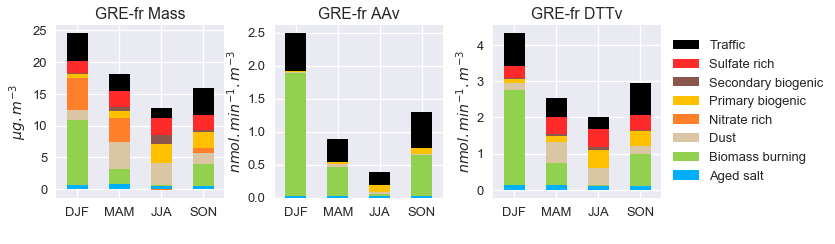

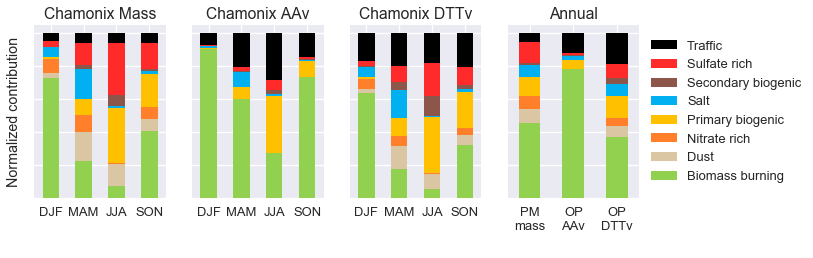

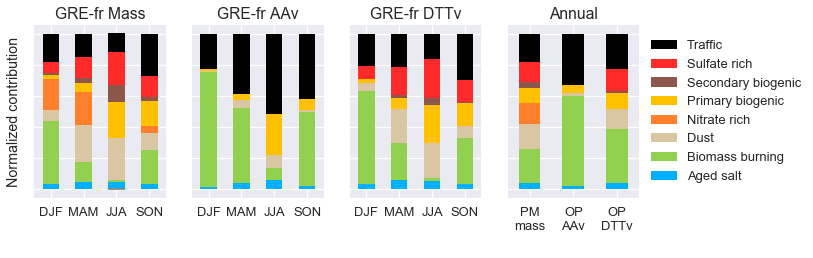

In [9]:
sns.set_context("talk")
for station in sto.values():
    #plot_barplot_contribution(station, ["AAv", "DTTv"])
    plot_barplot_contribution(station, list_OPtype, normalize=False)

for station in sto.values():
    #plot_barplot_contribution(station, ["AAv", "DTTv"])
    plot_barplot_contribution(station, list_OPtype, normalize=True)
   

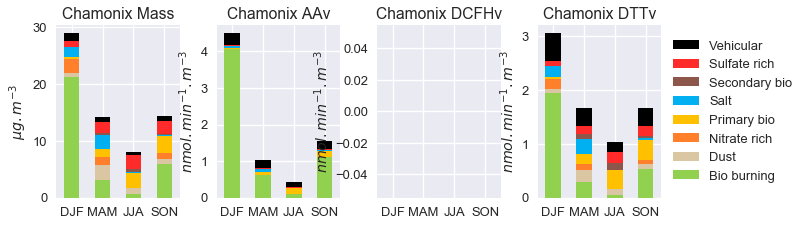

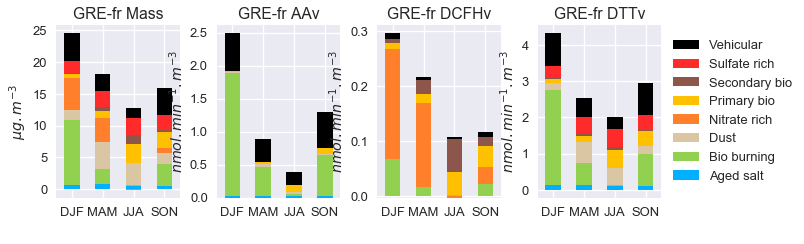

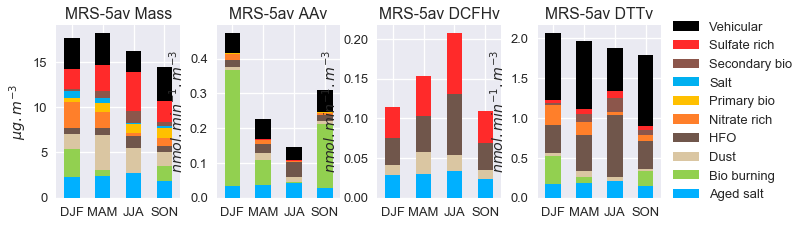

In [7]:
for name in ["Chamonix","GRE-fr","MRS-5av"]:
    plot_barplot_contribution(sto[name], list_OPtype=list_OPtype, normalize=False)